In [1]:
from app.face_reconstruction import FaceReconstructor

reconstructor = FaceReconstructor(root_dir="..", models_dir="../models", device="cuda")

/home/werserk/PycharmProjects/biometrics-hack/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/werserk/PycharmProjects/biometrics-hack/.venv/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. De

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/arcface.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


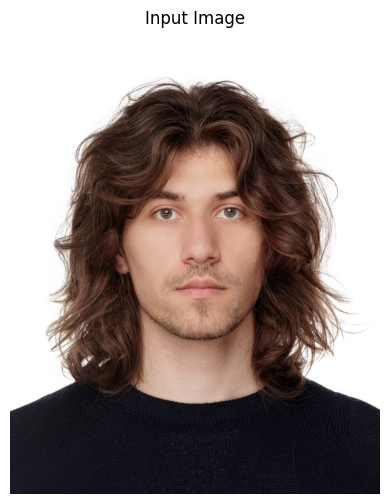

In [2]:
from matplotlib import pyplot as plt
import cv2

test_image_path = "../assets/examples/max.jpg"
test_image = cv2.imread(test_image_path)

plt.figure(figsize=(6, 6))
plt.imshow(test_image[:, :, ::-1])
plt.axis("off")
plt.title("Input Image")
plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

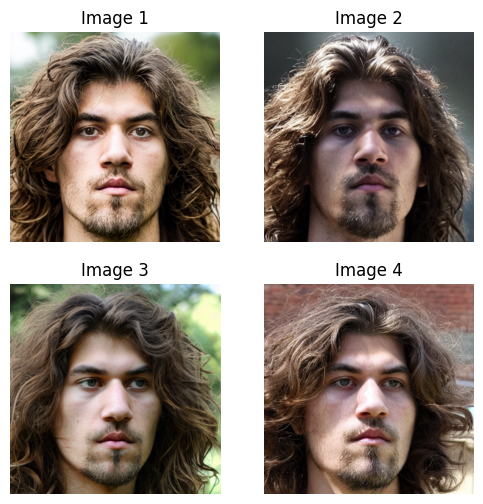

In [3]:
images = reconstructor.generate_similar_images(test_image, num_images=4)

plt.subplots(2, 2, figsize=(6, 6))
for i in range(len(images)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(f"Image {i + 1}")
plt.show()

In [4]:
from app.metric import Similarity

metric = Similarity()
metric.get_embedding(images[0])

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/werserk/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/werserk/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/werserk/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/werserk/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/werserk/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

array([-5.00599630e-02, -8.50041434e-02, -4.83571105e-02,  4.00411300e-02,
       -4.46040146e-02,  1.48068769e-02,  7.28935078e-02,  2.79964134e-02,
        1.19710723e-02, -1.03846341e-02,  4.16594781e-02, -5.36454469e-02,
       -4.12059687e-02, -9.35989805e-03, -5.44353202e-02,  5.66327944e-02,
       -1.02311186e-02, -4.31676209e-02, -4.86414097e-02, -5.06030731e-02,
        5.72350658e-02, -9.96950641e-03,  3.71912420e-02, -1.07286209e-02,
        3.21852341e-02,  1.49972048e-02, -5.06880619e-02, -7.16377348e-02,
        2.35776529e-02, -6.74136207e-02, -9.62544382e-02, -3.89602110e-02,
       -3.68963219e-02, -2.30408739e-02, -5.87027380e-03, -1.24669988e-02,
       -3.72926332e-02,  5.51093146e-02, -7.18677603e-03, -2.32513715e-02,
        6.38560653e-02,  8.87358636e-02,  5.98611943e-02, -1.36599869e-01,
       -2.96503473e-02, -9.50273797e-02, -5.88770881e-02,  4.02384289e-02,
       -1.34559171e-02,  1.01323701e-01,  2.12499090e-02, -1.58070344e-02,
       -2.25258376e-02,  

In [6]:
for i in range(len(images)):
    print(f"Compare image {i + 1} and test image: {metric(images[i], test_image)}")

Compare image 1 and test image: 0.7579519748687744
Compare image 2 and test image: 0.7090848684310913
Compare image 3 and test image: 0.7796698808670044
Compare image 4 and test image: 0.7177679538726807
